<a href="https://colab.research.google.com/github/GusevMihail/seamless_textute_generator/blob/master/dcgan_02_segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


## check GPU

In [96]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [98]:
printm()

Gen RAM Free: 11.5 GB  | Proc size: 2.2 GB
GPU RAM Free: 1335MB | Used: 10106MB | Util  88% | Total 11441MB



DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__




In [5]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import cv2
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from torch.utils import data

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
import os.path
import sys
if 'google' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir data
    !mkdir data/train
    if os.path.exists('data/train'):
        # !cp /content/drive/MyDrive/Colab/seamless_textute_generator/data/concrete_maps_1K.zip data
        # !unzip -q -n data/concrete_maps_1K.zip -d data/train
        !cp /content/drive/MyDrive/Colab/seamless_textute_generator/data/concrete_maps_100px.zip data
        !unzip -q -n data/concrete_maps_100px.zip -d data/train

Mounted at /content/drive


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [74]:
# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256

# number of image to show in grid
images_to_show = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 20

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




In [75]:
data_folder = r'data/train'
image_names = tuple(f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)))
# train_val, test_names = train_test_split(image_names, train_size = 0.8)
# train_names, val_names = train_test_split(train_val, train_size = 0.75)

In [76]:
from torch.utils import data
from typing import Any, Tuple

class TextureDataset(data.Dataset):

    def __init__(self, root_path: str, file_list: list, transforms: Any=None, 
                 cross_koeff: float=0.1, im_size: Tuple[int, int]=(224, 224)):
        super().__init__()
        self.root_path = root_path
        self.file_list = file_list
        self.transforms = transforms
        self.im_size = im_size
        self.cross_coeff = cross_koeff

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index: int) -> Tuple[np.array, np.array]:
        if index >= len(self.file_list):
            return self.__getitem__(np.random.randint(0, len(self.file_list)))

        image_path = os.path.join(self.root_path, self.file_list[index])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed['image']
            # mask = transformed['mask']

        X, mask = self.cut_cross(image)
        return X, mask, image

        # return image, image, image

    def cut_cross(self, img: np.array)->Tuple[np.array, np.array]:
        _, height, width= img.shape
        # Размеры креста
        cross_height = round(height * self.cross_coeff / 2)
        cross_width = round(width * self.cross_coeff / 2)

        # Индексы вырезания креста
        start_height_idx = round(height / 2 - cross_height)
        end_height_idx = round(height / 2 + cross_height)

        start_width_idx = round(width / 2 - cross_width)
        end_width_idx = round(width / 2 + cross_width)

        # Вырежем крест
        X = deepcopy(img)
        X[:, start_height_idx : end_height_idx] = 0
        X[..., start_width_idx : end_width_idx] = 0
        # Определим маску креста
        mask = torch.zeros(X.shape[1:])
        mask[start_height_idx : end_height_idx] = 1.
        mask[:, start_width_idx : end_width_idx] = 1.
        return X, mask

In [77]:

resize_transform = albu.Compose([albu.SmallestMaxSize(image_size),
                                 albu.RandomCrop(image_size, image_size),
                                #  albu.Resize(image_size, image_size),
                                 albu.Normalize(),
                                 ToTensorV2()])

In [81]:
dataset = TextureDataset(data_folder, image_names, resize_transform)
# val_data = TextureDataset(data_folder, val_names, resize_transform)
# test_data = TextureDataset(data_folder, test_names, resize_transform)

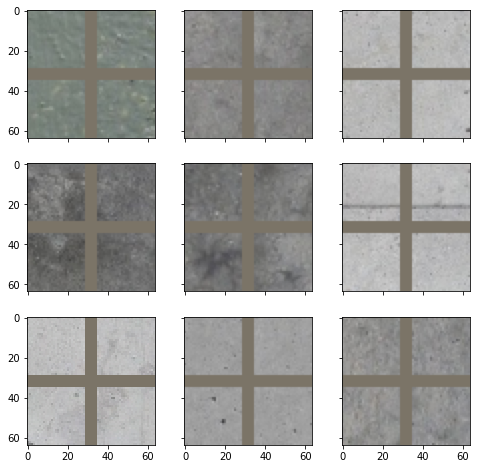

In [27]:
# look at the image
np.random.seed(42)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)

from copy import deepcopy

for fig_x in ax.flatten():
    i = np.random.choice(len(dataset), 1)[0]
    im , _, _ = dataset[i]
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
        )
    im = inv_normalize(im)
    fig_x.imshow(np.moveaxis(im.numpy(), 0, -1))
    fig_x.grid(False)

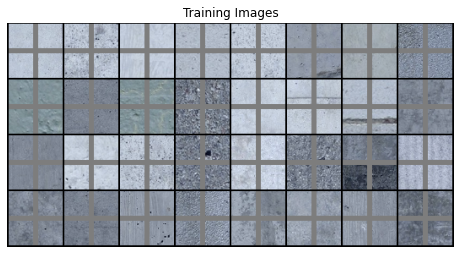

In [83]:

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:images_to_show], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




## model

In [85]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [86]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 =  nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 =  nn.MaxPool2d(2, 2, return_indices=True) # 16 -> 8
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 8 -> 4

        # bottleneck
        self.bottleneck_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, return_indices=True), # 4 -> 2
        )
        self.unpool = nn.MaxUnpool2d(2, 2)   # 2 -> 4
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(2, 2)# 4 -> 8
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 =  nn.MaxUnpool2d(2, 2)# 8 -> 16
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
  
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 16 -> 32
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0[0]))
        e2 = self.pool2(self.enc_conv2(e1[0]))
        e3 = self.pool3(self.enc_conv3(e2[0]))

        # bottleneck
        b1 = self.bottleneck_conv0(e3[0])
        b2 = self.bottleneck_conv1(self.unpool(*b1))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b2, e3[1]))
        d1 = self.dec_conv1(self.upsample1(d0, e2[1]))
        d2 = self.dec_conv2(self.upsample2(d1, e1[1]))
        d3 = self.dec_conv3(self.upsample3(d2, e0[1])) # no activation
        return d3

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [87]:
# Create the generator
netG = SegNet().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0)

Discriminator Code



In [88]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [89]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## trainig

In [90]:
lr = 1e-4
num_epochs = 1

In [91]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# get first batch
for fixed_noise,_,_ in dataloader:
    fixed_noise = fixed_noise.to(device)
    break

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [92]:
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=1, gamma=0.5)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=1, gamma=0.5)

In [93]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Dx_hist = []
DGz_1_hist = []
DGz_2_hist = []
iters = 0


In [94]:

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    print('Current learning rates:  '
            f'lr_D: {scheduler_D.get_last_lr()[0]:.2e} | '
            f'lr_G: {scheduler_G.get_last_lr()[0]:.2e} | ')
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[2].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = data[0].to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 100 == 0:
            print(f'[{epoch + 1:>2}/{num_epochs}] [{i:>4}/{len(dataloader)}]  '  
                f'Loss_D: {errD.item():.3f} | Loss_G: {errG.item():.3f} | '
                f'D(x): {D_x:.3f} | D(G(z)): {D_G_z1:.3f} / {D_G_z2:.3f} | '
                )
        
        # Save stats for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        Dx_hist.append(D_x)
        DGz_1_hist.append(D_G_z1)
        DGz_2_hist.append(D_G_z2)

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()[:images_to_show]
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

    scheduler_D.step()
    scheduler_G.step()
    printm()

Starting Training Loop...
Current learning rates:  lr_D: 1.00e-04 | lr_G: 1.00e-04 | 
[ 1/1] [   0/615]  Loss_D: 1.687 | Loss_G: 1.241 | D(x): 0.467 | D(G(z)): 0.501 / 0.354 | 
[ 1/1] [ 100/615]  Loss_D: 0.091 | Loss_G: 3.016 | D(x): 0.995 | D(G(z)): 0.082 / 0.062 | 
[ 1/1] [ 200/615]  Loss_D: 0.015 | Loss_G: 4.900 | D(x): 0.999 | D(G(z)): 0.015 / 0.012 | 
[ 1/1] [ 300/615]  Loss_D: 0.009 | Loss_G: 5.517 | D(x): 1.000 | D(G(z)): 0.009 / 0.007 | 


KeyboardInterrupt: ignored

In [95]:
printm()

Gen RAM Free: 11.5 GB  | Proc size: 2.2 GB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




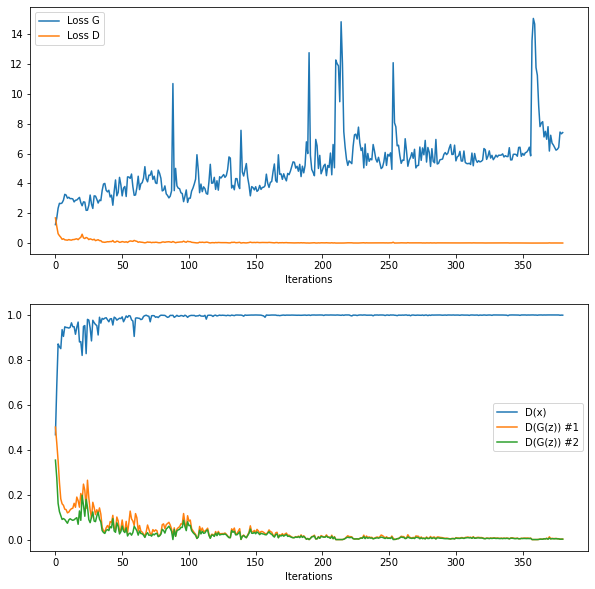

In [99]:
from matplotlib.ticker import MultipleLocator

# setup figure
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(10,10)

# plot on first axes
ax1.plot(G_losses, label='Loss G')
ax1.plot(D_losses, label='Loss D')

# plot on second axes
ax2.plot(Dx_hist, label='D(x)')
ax2.plot(DGz_1_hist, label='D(G(z)) #1')
ax2.plot(DGz_2_hist, label='D(G(z)) #2')

# format both axis
for ax in (ax1,ax2):
    ax.legend()
    ax.set(xlabel = 'Iterations')
    # set vertical grid lines to split epochs
    ax.xaxis.set_minor_locator(MultipleLocator(len(dataloader)))
    ax.grid(which='minor', axis='x')



**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




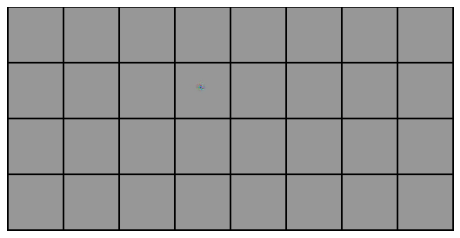

In [100]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




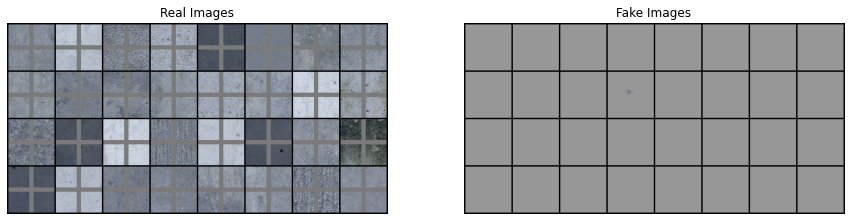

In [101]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:images_to_show], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__


